<div class="div_image pull-right">
    <div class = "image image_topic pull-right">
        <img src = "https://i.imgur.com/EGtMXKh.jpg?1">
    </div>
</div>

# <b>Capstone Project: Predicting Dota 2 Match Wins using Machine Learning and Recommender System (Data Cleaning and EDA)</b>


----

In Part 1, we scraped our data from the Dota Open API. In Part 2 of the project, we will now perform our data cleaning and analysis.


# <b>Import Libraries</b>


In [1]:
# Importing Libraries

import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')


In [2]:
# Set Pandas Options

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)


In [3]:
# Importing CSV file
dota2_df = pd.read_csv('Data\dota2_dataset_uncleaned.csv')

dota2_df.head()


,match_id,match_seq_num,radiant_win,start_time,duration,avg_mmr,num_mmr,lobby_type,game_mode,avg_rank_tier,num_rank_tier,cluster,radiant_team,dire_team
0,6667194000,5575198916,False,1658141589,1761,3339.0,3.0,7,22,62,6,144,"135,93,74,20,5","25,114,112,14,31"
1,6667193909,5575199706,False,1658141579,1815,2765.0,2.0,7,22,41,4,172,"11,14,38,30,26","44,8,136,98,91"
2,6667193907,5575216552,True,1658141574,2767,NaN,NaN,7,22,22,3,182,"81,67,110,101,74","71,113,99,123,107"
3,6667193906,5575210106,False,1658141574,2438,2930.0,3.0,7,3,41,9,232,"74,13,84,2,19","16,106,112,88,73"
4,6667193904,5575219926,False,1658141573,3053,1393.0,1.0,7,22,25,6,152,"74,41,14,90,93","135,47,1,33,26"


In [4]:
dota2_df.shape

(2478900, 14)

We see that we have 2,478,900 rows of data, and 14 columns in our dataframe.

---

## Data Dictionary

| Name          | data_type | Value(s)           | Description                                                                                                          |
| ------------- | --------- | ------------------ | -------------------------------------------------------------------------------------------------------------------- |
| match_id      | int       | -                  | Match Identification Number                                                                                          |
| match_seq_num | int       | -                  | Match Sequence Number                                                                                                |
| radiant_win   | Boolean   | True/ False        | True: Radiant Team Wins False: Radiant Team Loses                                                                    |
| start_time    | int       | -                  | Start Time of Match                                                                                                  |
| duration      | int       | -                  | Match Duration                                                                                                       |
| avg_mmr       | float     | -                  | Average MMR of players in match. A higher value indicates more skilled players                                       |
| num_mmr       | float     | -                  | Number of players with have their MMR public.                                                                        |
| lobby_type    | int       | 0, 7               | Type of match. 0: Normal Match 7: Ranked Match                                                                       |
| game_mode     | int       | 2, 3, 4, 5, 16, 22 | Type of game. 2: Captain's Mode 3: Random Draft 4: Single Draft 5: All Random 16: Captain's Draft 22: All Draft      |
| avg_rank_tier | int       | -                  | Average Rank Tier of players in match. First number indicates the rank tier, second number indicates number of stars |
| num_rank_tier | int       | -                  | Number of players in the match that have their rank profile public                                                   |     |
| cluster       | int       | -                  | Server cluster where match take place                                                                                |
| radiant_team  | str       | -                  | String of Hero_Ids of radiant team                                                                                   |
| dire_team     | str       | -                  | String of Hero_Ids of dire team                                                                                      |


---

# <b>Data EDA</b>


For EDA, we will be using the Panda Profiling Library to generate our EDA report for the various categories in our dataframe.


In [5]:
# Generate Panda Profiling Report
profile = ProfileReport(dota2_df, title='Pandas Profiling report')
profile


## <b>Key insights from Pandas profiling report</b>

### _Radiant Win_

Our target variable (radiant_win) data is balanced, with 1,234,680 wins and 1,233,220 losses. This means we won't need to generate synthetic data when we do our machine learning in future.


### _Duration_

Our histogram plot shows that match durations data is normally distributed. We see that a match has a median duration of 2367 seconds, or about 39.5 minutes. However, we note that there are some games that last very short. Generally, this is a sign that the match is lopsided due to external reasons (mainly due to people leaving the match). We will need to remove some of these outliers


### _Avg MMR / Num_MMR_

Matchmaking Rank points, or MMR for short, play a vital role in ensuring players are matched to games within their skill level. MMR is a direct reflection of a player's skill where the more wins a player accumulates, the higher the MMR. MMR is also used to Our histogram plot shows that average MMR data is normally distributed, with the mean MMR around 2944. However, we note that 33% of the data is missing. This could be due to Valve's privacy policy to not track MMR of individuals unless the person sets it public.

This missing data corresponds to the num_MMR data as well. We see that not many people have set their MMR public, with each match only having 2 players on average being tracked by the API.


### _Lobby Type_

In Dota 2, there are a few lobby types. The main lobby we want to target is the ranked match lobby as this is where wins and losses are tracked. Hence, most players that take part in these matches are at their most competitive as most players will want to reach the highest rank as possible.

We see that about 82% of games scrapped are ranked matches, which is good for our dataset. We will be using this as the bulk of our data for our matches.


### _Avg Rank Tier/ Num Rank Tier_

In contrast with MMR which is a hidden figure that the matchmaking algorithm uses to match similar skill players together, rank is a public system that players can use to track their rank progress. There are currently 8 ranks in Dota 2, and each rank has 5 subranks, denoted by the number of stars. Match wins in the rank lobby will allow players to gain stars, which allows them to increase their rank. Losses consequently will also cause players to lose stars, similarly causing them to drop ranks. The figure below is a summary of the rank and MMR system in Dota 2

<div class="div_image pull-right">
    <div class = "image image_topic pull-right">
        <img src = "https://www.esports.net/wp-content/uploads/2021/08/dota2-rank-1-1024x578.jpg">
    </div>
</div>


We see that the average player's rank is 35, which would correspond to Crusader 5. This would generally be a casual player who would not know the intricacies of the game very well. 

### _Game Mode_

There are various game modes that are in Dota 2 catering to different types of play. The main game mode we will be examine is the "All Pick", or "All Draft" mode. Details of how it works can be found in the Appendix.

We see that the "All Pick" Mode, denoted by Game Mode 22, forms 90.9% of our dataset. This shows that the majority of players play ranked mode.


### _Radiant Team / Dire Team_

Each team contains a string of 5 numbers, corresponding to the five unique Hero_IDs in each team (see Appendix for list of Heroes). Each match contains 10 unique heroes with no duplicates allowed across both teams.

Heroes can be classified as “ranged” i.e.,able to attack from a distance or “melee” i.e., able to attack only when nearby. DotA 2 heroes are also broadly classified into the following four categories, based upon their larger role and impact in the game:

 - Carry -  A carry’s primary task is to obtain as much gold and experience, as fast as possible and obtain high level items using that gold. A carry’s ability to kill opponent heroes usually exponentially increases as a function of their items and this is reflected in what is known as the “snowball” effect in the DotA 2 community i.e., a well played carry hero often leads his / her team to victory almost single-handedly. Hence, often such a role is taken by the highest skilled player in the team in order to maximise the team's chance for success.

 - Support - A support offers aid to the primary carry heroes, defends the carry heroes against enemy threats, buys items such as couriers and wards, which aid the carry in their hero progression. A support hero may sacrifice himself / herself to save the carry and exists solely to ensure that the carry does what it is intended to do. Usually, these heroes are much stronger than carry heroes early in the game, during which time, carry heroes are quite weak and susceptible to deaths.

 - Initiator - An initiator is one who is critical in team fights i.e., fights where at least 3 out of 5 heroes in each team engage in each other in a climactic showdown. Initiators usually subsist under the above classes. Their primary role is to spark off team fights, by enabling their own team to start off on an advantageous footing. Such heroes usually have large area of effect skills that disable and / or “stun” enemy heroes into being inactive for a duration of time.

 - Disabler - A disabler is one who seeks to lock down their opponents and as the name suggest, disable them to allow for carries to kill them easily They often build utility items to enhance their disables. There are a multitude of disabling abilities to cripple their opponents.


This is not to say that this is the only rigid classification of heroes in the game. It is extremely flexible in that heroes can sometimes switch roles such as the “support” becoming a carry and vice versa somewhere in the middle of a game, the existence of hybrid roles such as the “support-initiator” and much more. 


----

# Data Filtering and Transformation

To minimise external factors that could create noise in our data, we will only be keeping data that fulfil the following criteria:

- Ranked Matches. This is to ensure that players are trying their best to win and will optimise their hero to the best of their ability to achieve the highest chance of success.

- All Draft Matches. This will ensure that all heroes will be available to be picked for comparison

- Matches where the average rank is above 65 (see Appendix C for full reasons why). This is to ensure we only include matches with high-skilled players and will encompass about the top 5% of players. We would be only considering matches with players who have a deep understanding of the game and will be able to bring our the hero's full potential.

- Duration above 15 minutes. We will want to ensure matches are fully played out to victory and that there are no lopsided matches due to external factors such as people leaving the match, or being idle in the match.

We will one-hot-encode our data for both radiant team and dire team separately to indicate the presence of each hero on each team. This method would allow the algorithm to consider not only the presence of the hero in the match, but to also indicate which team the hero was on.

We also will create a dataframe to hold our winrates for further EDA later.

In [6]:
# Keep ranked matches, all-draft matches, average rank above 70, and duration above 15 mins.

dota2_df = dota2_df.loc[(dota2_df["game_mode"] == 22) & (
    dota2_df["lobby_type"] == 7) & (dota2_df["avg_rank_tier"] > 70) & (dota2_df["duration"] > 900)]


In [7]:
#Creating a dataframe to hold our winrate EDA
dota2_dire_df = dota2_df

dota2_dire_df = dota2_dire_df.rename(
    columns={'radiant_team': 'dire_team', 'dire_team': 'radiant_team'})

dota2_dire_df["radiant_win"] = dota2_dire_df["radiant_win"].map(
    {True: False, False: True})

win_df = pd.concat([dota2_df, dota2_dire_df], axis=0, ignore_index=True)
win_df = win_df.loc[win_df['avg_rank_tier'] > 70]

In [8]:
# Generate one-hot-encoding for radiant and dire team

dota2_df = pd.concat([dota2_df, (dota2_df["radiant_team"].str.get_dummies(
    sep=',').add_prefix('R'))], axis=1).drop("radiant_team", axis=1)

dota2_df = pd.concat([dota2_df, (dota2_df["dire_team"].str.get_dummies(
    sep=',').add_prefix('D'))], axis=1).drop("dire_team", axis=1)


In [9]:
# Generate one-hot-encoding for radiant and dire team

win_df = pd.concat([win_df, (win_df["radiant_team"].str.get_dummies(
    sep=',').add_prefix('R'))], axis=1).drop("radiant_team", axis=1)

win_df = pd.concat([win_df, (win_df["dire_team"].str.get_dummies(
    sep=',').add_prefix('D'))], axis=1).drop("dire_team", axis=1)


As we are trying to predict match wins based on hero compositions solely, we will also be dropping columns that do not contain hero data.

In [10]:
# Drop non important columns
dota2_df = dota2_df.drop(columns=["match_id", "match_seq_num", "start_time", "duration",
                         "num_mmr", "lobby_type", "game_mode", "num_rank_tier", "cluster", "avg_mmr", "avg_rank_tier"]).dropna()
win_df = win_df.drop(columns=["match_id", "match_seq_num", "start_time", "duration",
                         "num_mmr", "lobby_type", "game_mode", "num_rank_tier", "cluster", "avg_mmr", "avg_rank_tier"]).dropna()


In [11]:
#Dropping duplicates
dota2_df = dota2_df.drop_duplicates()

In [12]:
dota2_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 77994 entries, 68 to 2478899
Columns: 247 entries, radiant_win to D99
dtypes: bool(1), int64(246)
memory usage: 147.1 MB


We are left with 77,994 rows after filtering our data.

# Win Rates

In a game of Dota 2, the individual win rates of heroes are often used as a metric to indicate the strength of a hero. Intuitively, a hero's win rate is a proxy of the strength of a hero. Hence, independently, choosing the hero with the highest win rate would be the best choice in a match.

We will hence calculate the individual win rate of each hero.

In [13]:
win_df.head()

,radiant_win,R1,R10,R100,R101,R102,R103,R104,R105,R106,R107,R108,R109,R11,R110,R111,R112,R113,R114,R119,R12,R120,R121,R123,R126,R128,R129,R13,R135,R136,R137,R14,R15,R16,R17,R18,R19,R2,R20,R21,R22,R23,R25,R26,R27,R28,R29,R3,R30,R31,R32,R33,R34,R35,R36,R37,R38,R39,R4,R40,R41,R42,R43,R44,R45,R46,R47,R48,R49,R5,R50,R51,R52,R53,R54,R55,R56,R57,R58,R59,R6,R60,R61,R62,R63,R64,R65,R66,R67,R68,R69,R7,R70,R71,R72,R73,R74,R75,R76,R77,R78,R79,R8,R80,R81,R82,R83,R84,R85,R86,R87,R88,R89,R9,R90,R91,R92,R93,R94,R95,R96,R97,R98,R99,D1,D10,D100,D101,D102,D103,D104,D105,D106,D107,D108,D109,D11,D110,D111,D112,D113,D114,D119,D12,D120,D121,D123,D126,D128,D129,D13,D135,D136,D137,D14,D15,D16,D17,D18,D19,D2,D20,D21,D22,D23,D25,D26,D27,D28,D29,D3,D30,D31,D32,D33,D34,D35,D36,D37,D38,D39,D4,D40,D41,D42,D43,D44,D45,D46,D47,D48,D49,D5,D50,D51,D52,D53,D54,D55,D56,D57,D58,D59,D6,D60,D61,D62,D63,D64,D65,D66,D67,D68,D69,D7,D70,D71,D72,D73,D74,D75,D76,D77,D78,D79,D8,D80,D81,D82,D83,D84,D85,D86,D87,D88,D89,D9,D90,D91,D92,D93,D94,D95,D96,D97,D98,D99
0,False,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,True,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,True,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0


In [14]:
# Calculate individual winrate for each hero

winrate_df = pd.DataFrame()

winrate_df["winrate"] = (
    (win_df.loc[win_df["radiant_win"] == True].sum())) / (win_df.sum())

winrate_df = winrate_df.transpose()
winrate_df.head()


,radiant_win,R1,R10,R100,R101,R102,R103,R104,R105,R106,R107,R108,R109,R11,R110,R111,R112,R113,R114,R119,R12,R120,R121,R123,R126,R128,R129,R13,R135,R136,R137,R14,R15,R16,R17,R18,R19,R2,R20,R21,R22,R23,R25,R26,R27,R28,R29,R3,R30,R31,R32,R33,R34,R35,R36,R37,R38,R39,R4,R40,R41,R42,R43,R44,R45,R46,R47,R48,R49,R5,R50,R51,R52,R53,R54,R55,R56,R57,R58,R59,R6,R60,R61,R62,R63,R64,R65,R66,R67,R68,R69,R7,R70,R71,R72,R73,R74,R75,R76,R77,R78,R79,R8,R80,R81,R82,R83,R84,R85,R86,R87,R88,R89,R9,R90,R91,R92,R93,R94,R95,R96,R97,R98,R99,D1,D10,D100,D101,D102,D103,D104,D105,D106,D107,D108,D109,D11,D110,D111,D112,D113,D114,D119,D12,D120,D121,D123,D126,D128,D129,D13,D135,D136,D137,D14,D15,D16,D17,D18,D19,D2,D20,D21,D22,D23,D25,D26,D27,D28,D29,D3,D30,D31,D32,D33,D34,D35,D36,D37,D38,D39,D4,D40,D41,D42,D43,D44,D45,D46,D47,D48,D49,D5,D50,D51,D52,D53,D54,D55,D56,D57,D58,D59,D6,D60,D61,D62,D63,D64,D65,D66,D67,D68,D69,D7,D70,D71,D72,D73,D74,D75,D76,D77,D78,D79,D8,D80,D81,D82,D83,D84,D85,D86,D87,D88,D89,D9,D90,D91,D92,D93,D94,D95,D96,D97,D98,D99
winrate,1.0,0.450322,0.486805,0.493708,0.516226,0.518304,0.499454,0.488755,0.470114,0.481672,0.513942,0.46732,0.477323,0.487331,0.485536,0.500154,0.539528,0.550812,0.467074,0.46106,0.506805,0.484003,0.443978,0.490226,0.487531,0.451409,0.459324,0.516136,0.529229,0.507584,0.483568,0.499241,0.508656,0.485492,0.454793,0.471776,0.506969,0.486467,0.509918,0.49923,0.519114,0.465293,0.511557,0.449611,0.506386,0.493361,0.443823,0.50976,0.462993,0.491711,0.532134,0.534353,0.515986,0.488336,0.485744,0.523214,0.525741,0.465037,0.51218,0.516083,0.516481,0.498813,0.490975,0.458819,0.477044,0.501784,0.504649,0.487965,0.458933,0.525878,0.5313,0.48831,0.486353,0.4733,0.467094,0.500275,0.511013,0.545735,0.473943,0.514653,0.49556,0.505262,0.55803,0.516021,0.490473,0.497195,0.514023,0.574375,0.48569,0.478691,0.488929,0.50953,0.525832,0.473544,0.501488,0.522895,0.496214,0.490776,0.499086,0.558069,0.529662,0.491296,0.528997,0.559859,0.487825,0.537166,0.523212,0.501558,0.493196,0.473592,0.482454,0.515971,0.527253,0.514314,0.512702,0.530007,0.569712,0.500492,0.490776,0.471595,0.503949,0.488812,0.466287,0.523929,0.549678,0.513195,0.506292,0.483774,0.481696,0.500546,0.511245,0.529886,0.518328,0.486058,0.53268,0.522677,0.512669,0.514464,0.499846,0.460472,0.449188,0.532926,0.53894,0.493195,0.515997,0.556022,0.509774,0.512469,0.548591,0.540676,0.483864,0.470771,0.492416,0.516432,0.500759,0.491344,0.514508,0.545207,0.528224,0.493031,0.513533,0.490082,0.50077,0.480886,0.534707,0.488443,0.550389,0.493614,0.506639,0.556177,0.49024,0.537007,0.508289,0.467866,0.465647,0.484014,0.511664,0.514256,0.476786,0.474259,0.534963,0.48782,0.483917,0.483519,0.501187,0.509025,0.541181,0.522956,0.498216,0.495351,0.512035,0.541067,0.474122,0.4687,0.51169,0.513647,0.5267,0.532906,0.499725,0.488987,0.454265,0.526057,0.485347,0.50444,0.494738,0.44197,0.483979,0.509527,0.502805,0.485977,0.425625,0.51431,0.521309,0.511071,0.49047,0.474168,0.526456,0.498512,0.477105,0.503786,0.509224,0.500914,0.441931,0.470338,0.508704,0.471003,0.440141,0.512175,0.462834,0.476788,0.498442,0.506804,0.526408,0.517546,0.484029,0.472747,0.485686,0.487298,0.469993,0.430288,0.499508,0.509224,0.528405,0.496051,0.511188,0.533713,0.476071


In [15]:
# Dropping radiant_win column
winrate_df.drop(columns=['radiant_win'], inplace=True)


We will then plot the heroes with the highest win rates.

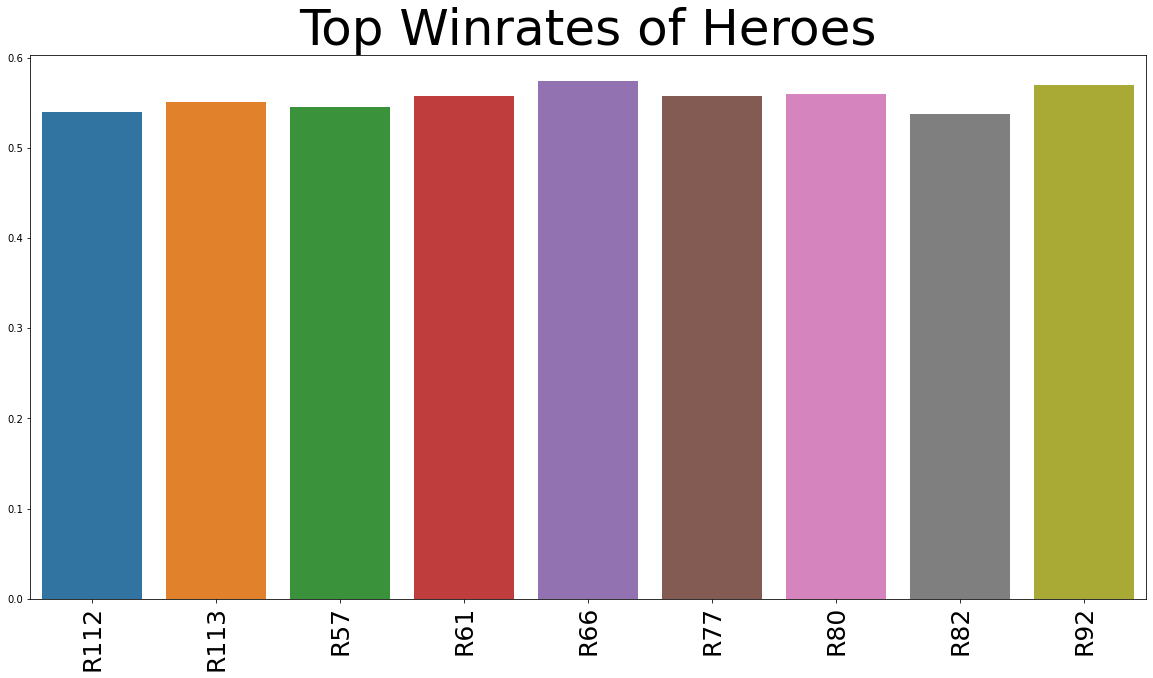

In [18]:
# Plotting winrate of individual heroes above 53.5%
columns = []
for column in winrate_df.columns:
    if winrate_df[column]['winrate'] > 0.535: #for winrates above 54%
        if 'R' in column: #for column names with 'radiant' 
            columns.append(column)


plt.figure(figsize=(20, 10))
sns.barplot(data=winrate_df[columns])
plt.xticks(rotation=90, fontsize=25)
plt.title("Top Winrates of Heroes", fontsize = 50)
plt.show()


From the graph, we can see the top 9 Heroes (no particular order) with a winrate above 53.5%: 

1. Winter Wyvern
2. Arc Warden
3. Omniknight
4. Broodmother
5. Chen
6. Lycan
7. Lone Druid
8. Meepo
9. Visage

In context, having a winrate above 50% is considered good as the matchmaking system in Dota 2 will try to match players of similar skill levels accordingly. In a zero sum game, the expected winrate of a player would then be 50% only. Thus, having a winrate above 50% would give an edge to the player and allow them to progress further in their rank.

Based on the graph, we see that the top win rate heroes fulfil either the carry or support role. This makes sense given that carries in the hands of a skilled player can bring a team to victory. Support heroes are also needed to ensure that carry heroes survive long enough to pick off their opponents. This leans into the common perception that playing a carry with a good support is instrumental to a team's victory.

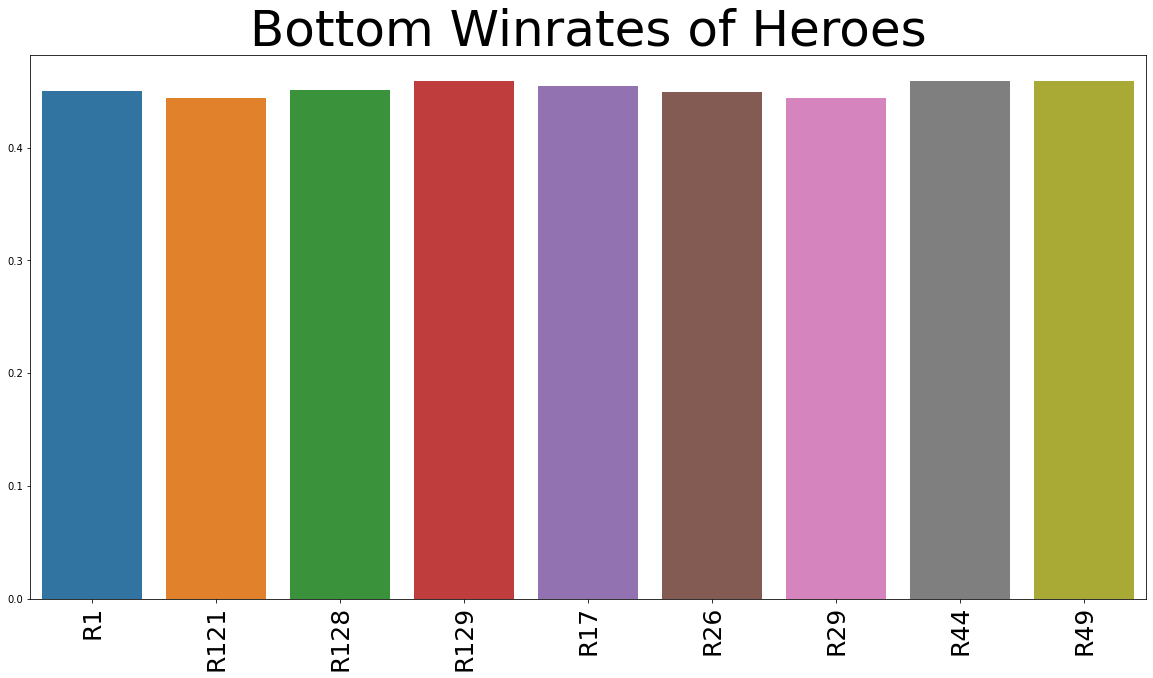

In [19]:
# Plotting winrate of individual heroes below 46%
columns = []
for column in winrate_df.columns:
    if winrate_df[column]['winrate'] <0.46: #for winrates above 54%
        if 'R' in column: #for column names with 'radiant' 
            columns.append(column)


plt.figure(figsize=(20, 10))
sns.barplot(data=winrate_df[columns])
plt.xticks(rotation=90, fontsize=25)
plt.title("Bottom Winrates of Heroes", fontsize = 50)
plt.show()

In contrast, we can compare with the heroes with the lowest winrate. We can see from the graph that these are: 

1. Anti-Mage
2. Grimstroke
3. Snapfire
4. Mars
5. Storm Spirit
6. Lion
7. Tidehunter
8. Phantom Assassin
9. Dragon Knight

*Insert analysis of heroes meta*

# Exporting Preprocessed Data


We will now be exporting our preprocessed data for our data modelling.

In [20]:
dota2_df.to_csv("Data\preprocessed_data.csv", index=False)


# <b>Appendix</b>


## Appendix A - Ranked Game mode

_Taken from https://dota2.fandom.com/wiki/Game_modes_

The All Pick mode in ranked matches works different than the regular All Pick mode, and is called "Ranked Matchmaking".

Banning Phase:

- All players have 15 seconds to vote for a hero to be banned.

- A hero may only be voted once. Two players cannot vote for the same hero.
- The game displays heroes as they are voted on, but not who voted.
- After 15 seconds, each vote has a 50% chance of succeeding. The chances are rolled for each voted hero individually.
- The system automatically bans additional random heroes based on their ban rate at the MMR bracket the match plays on. This always results in a total of 16 banned heroes.

Pick Phase:

- Players pick heroes over 3 rounds.
- The first two rounds last 25 seconds. Two players from each team pick a hero.
- The last round lasts 20 seconds. One player from each team picks a hero.
- If the timer expires, players who haven't picked lose 2 Gold gold per second.
- Player picks are not revealed until their round ends. If two players pick the same hero, that hero is banned and the round restarts. This can happen maximum twice. If two players pick the same hero for the third time, whoever picks the hero first will get the hero, and the other player will have time to repick their hero.

- If a player fails to pick a hero and loses gold for more than 30 seconds, they are assigned a random hero.
- If a player does not enter battle with his hero until after the 0:00 mark, that player's gold is removed and distributed to all of the players on his team. Similar to if he had abandoned, but it does not count as an abandon for the sake of the game being safe to leave.

Randoming:

- Players can let the system pick a random hero from the entire hero pool, except their 25 least played ones.

- Only the players of the first round may random a hero. All other players have to pick.
- The randomed hero cannot be repicked.
- Randoming a hero gives the player of the randomed hero a Faerie Fire and an Enchanted Mango at the beginning of the game (i.e. swapping cannot be used to move the items to another hero).


## Appendix B: Hero ID list


- To note that there are some IDs that are not assigned to any heroes. This is denoted with a dash.

| Hero_id | Name                | Primary Role | Melee/Ranged |
| ------- | ------------------- | ------------ | ------------ |
| 1       | Anti-Mage           | Carry        | Melee        |
| 2       | Axe                 | Initiator    | Melee        |
| 3       | Bane                | Disabler     | Ranged       |
| 4       | Bloodseeker         | Carry        | Melee        |
| 5       | Crystal Maiden      | Support      | Ranged       |
| 6       | Drow Ranger         | Carry        | Ranged       |
| 7       | Earthshaker         | Initiator    | Melee        |
| 8       | Juggernaut          | Carry        | Melee        |
| 9       | Mirana              | Support      | Ranged       |
| 10      | Morphling           | Carry        | Ranged       |
| 11      | Shadowfiend         | Carry        | Ranged       |
| 12      | Phantom Lancer      | Carry        | Melee        |
| 13      | Puck                | Initiator    | Ranged       |
| 14      | Pudge               | Disabler     | Melee        |
| 15      | Razor               | Carry        | Ranged       |
| 16      | Sand King           | Initiator    | Melee        |
| 17      | Storm Spirit        | Carry        | Ranged       |
| 18      | Sven                | Initiator    | Melee        |
| 19      | Tiny                | Carry        | Melee        |
| 20      | Vengeful Spirit     | Support      | Ranged       |
| 21      | Windranger          | Disabler     | Ranged       |
| 22      | Zeus                | Carry        | Ranged       |
| 23      | Kunkka              | Disabler     | Melee        |
| 24      | -                   | -            | -            |
| 25      | Lina                | Support      | Ranged       |
| 26      | Lion                | Disabler     | Ranged       |
| 27      | Shadow Shaman       | Disabler     | Ranged       |
| 28      | Slardar             | Initiator    | Melee        |
| 29      | Tidehunter          | Initiator    | Melee        |
| 30      | Witch Doctor        | Support      | Ranged       |
| 31      | Lich                | Support      | Ranged       |
| 32      | Riki                | Carry        | Melee        |
| 33      | Enigma              | Disabler     | Ranged       |
| 34      | Tinker              | Carry        | Ranged       |
| 35      | Sniper              | Carry        | Ranged       |
| 36      | Necrophos           | Carry        | Ranged       |
| 37      | Warlock             | Initiator    | Ranged       |
| 38      | Beastmaster         | Disabler     | Melee        |
| 39      | Queen of Pain       | Carry        | Ranged       |
| 40      | Venomancer          | Support      | Ranged       |
| 41      | Faceless Void       | Initiator    | Melee        |
| 42      | Wraith King         | Disabler     | Melee        |
| 43      | Death Prophet       | Support      | Ranged       |
| 44      | Phantom Assassin    | Carry        | Melee        |
| 45      | Pugna               | Support      | Ranged       |
| 46      | Templar Assassin    | Carry        | Ranged       |
| 47      | Viper               | Carry        | Ranged       |
| 48      | Luna                | Carry        | Ranged       |
| 49      | Dragon Knight       | Carry        | Melee        |
| 50      | Dazzle              | Support      | Ranged       |
| 51      | Clockwerk           | Initiator    | Melee        |
| 52      | Leshrac             | Carry        | Ranged       |
| 53      | Nature's Prophet    | Support      | Ranged       |
| 54      | Lifestealer         | Carry        | Melee        |
| 55      | Dark Seer           | Disabler     | Melee        |
| 56      | Clinkz              | Carry        | Ranged       |
| 57      | Omniknight          | Support      | Melee        |
| 58      | Enchantress         | Support      | Ranged       |
| 59      | Huskar              | Carry        | Ranged       |
| 60      | Night Stalker       | Initiator    | Melee        |
| 61      | Broodmother         | Support      | Melee        |
| 62      | Bounty Hunter       | Disabler     | Melee        |
| 63      | Weaver              | Carry        | Ranged       |
| 64      | Jakiro              | Support      | Ranged       |
| 65      | Bat Rider           | Initiator    | Ranged       |
| 66      | Chen                | Support      | Ranged       |
| 67      | Spectre             | Carry        | Melee        |
| 68      | Ancient Apparition  | Support      | Ranged       |
| 69      | Doom                | Initiator    | Melee        |
| 70      | Ursa                | Carry        | Melee        |
| 71      | Spirit Breaker      | Initiator    | Melee        |
| 72      | Gyrocopter          | Carry        | Ranged       |
| 73      | Alchemist           | Carry        | Melee        |
| 74      | Invoker             | Disabler     | Ranged       |
| 75      | Silencer            | Initiator    | Ranged       |
| 76      | Outworld Destroyer  | Carry        | Ranged       |
| 77      | Lycan               | Carry        | Melee        |
| 78      | Brewmaster          | Initiator    | Melee        |
| 79      | Shadow Demon        | Support      | Ranged       |
| 80      | Lone Druid          | Carry        | Melee        |
| 81      | Chaos Knight        | Carry        | Melee        |
| 82      | Meepo               | Carry        | Melee        |
| 83      | Treant Protector    | Support      | Melee        |
| 84      | Ogre Magi           | Support      | Melee        |
| 85      | Undying             | Support      | Melee        |
| 86      | Rubick              | Support      | Ranged       |
| 87      | Disruptor           | Disabler     | Ranged       |
| 88      | Nyx Assassin        | Initiator    | Melee        |
| 89      | Naga Siren          | Carry        | Melee        |
| 90      | Keeper of the Light | Support      | Ranged       |
| 91      | IO                  | Support      | Ranged       |
| 92      | Visage              | Support      | Ranged       |
| 93      | Slark               | Carry        | Melee        |
| 94      | Medusa              | Carry        | Ranged       |
| 95      | Troll Warlord       | Carry        | Ranged       |
| 96      | Centaur Warrunner   | Initiator    | Melee        |
| 97      | Magnus              | Initiator    | Melee        |
| 98      | Timbersaw           | Support      | Melee        |
| 99      | Bristleback         | Carry        | Melee        |
| 100     | Tusk                | Initiator    | Melee        |
| 101     | Skywrath Mage       | Support      | Ranged       |
| 102     | Abaddon             | Support      | Melee        |
| 103     | Elder Titan         | Initiator    | Melee        |
| 104     | Legion Commander    | Disabler     | Melee        |
| 105     | Techies             | Disabler     | Ranged       |
| 106     | Ember Spirit        | Carry        | Melee        |
| 107     | Earth Spirit        | Disabler     | Melee        |
| 108     | Underlord           | Support      | Melee        |
| 109     | Terrorblade         | Carry        | Melee        |
| 110     | Phoenix             | Support      | Ranged       |
| 111     | Oracle              | Support      | Ranged       |
| 112     | Winter Wyvern       | Support      | Ranged       |
| 113     | Arc Warden          | Carry        | Ranged       |
| 114     | Monkey King         | Carry        | Melee        |
| 115     | -                   | -            | -            |
| 116     | -                   | -            | -            |
| 117     | -                   | -            | -            |
| 118     | -                   | -            | -            |
| 119     | Dark Willow         | Support      | Ranged       |
| 120     | Pangolier           | Carry        | Melee        |
| 121     | Grimstroke          | Disabler     | Ranged       |
| 122     | -                   | -            | -            |
| 123     | Hoodwink            | Support      | Ranged       |
| 124     | -                   | -            | -            |
| 125     | -                   | -            | -            |
| 126     | Void Spirit         | Carry        | Melee        |
| 127     | -                   | -            | -            |
| 128     | Snapfire            | Support      | Ranged       |
| 129     | Mars                | Initiator    | Melee        |
| 130     | -                   | -            | -            |
| 131     | -                   | -            | -            |
| 132     | -                   | -            | -            |
| 133     | -                   | -            | -            |
| 134     | -                   | -            | -            |
| 135     | Dawnbreaker         | Carry        | Melee        |
| 136     | Marci               | Initiator    | Melee        |
| 137     | Primal Beast        | Initiator    | Melee        |


## Appendix C : Divine Rank

*Excerpt from https://theglobalgaming.com/gaming/divine-dota-2*

Divine is the seventh tier of the Dota 2 ranking system, located between Ancient and Immortal. Many Divine players create their own teams and participate in the professional leagues. Most of the gamers on this level play Dota 2 every day, for 5 hours and more on average. The Divine tier goes from 4620 to 5420 MMR. 

Divine players know almost everything about the game. Oftentimes, the main difference between Immortal and Divine players is in their focus and talent. You might have players who are mechanically gifted, but they cannot penetrate Immortal due to their lack of focus and commitment. Most players will need more than 3700 hours to reach the Divine rank (if they reach it). 